In [1]:
import torch
import random
import numpy as np
from torch import nn, optim
from torch.utils import data
import torch.nn.functional as F
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

In [2]:
dataset = np.load("QIS_EXAM_200Events.npz", allow_pickle=True)
print(dataset.files)

['training_input', 'test_input']


In [3]:
training_data = dataset["training_input"].tolist()
test_data = dataset["test_input"].tolist()

In [4]:
train_features = np.concatenate((training_data["0"], training_data["1"]), axis=0)

In [5]:
train_labels = np.array([0]*50 + [1]*50)

In [6]:
input_data = list(zip(train_features,train_labels))
random.shuffle(input_data)

In [7]:
train_x, train_y = zip(*input_data)

In [8]:
train_x = torch.from_numpy(np.array(train_x)).float()
train_y = torch.from_numpy(np.array(train_y)).long()

In [28]:
dataset = data.TensorDataset(train_x,train_y)
trainloader = data.DataLoader(dataset, batch_size=25)

In [25]:
test_x = np.concatenate((test_data["0"],test_data["1"]), axis=0)
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(np.array([0]*50 + [1] * 50)).long()

test_dataset = data.TensorDataset(test_x,test_y)
test_loader = data.DataLoader(test_dataset)

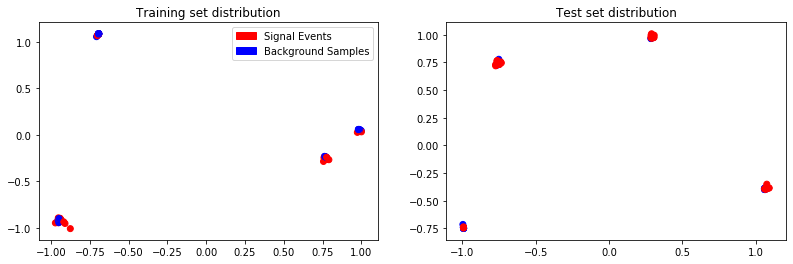

In [12]:
from sklearn.decomposition import PCA

# visualized the data after reducing the dimensionality to 2, to get an idea on the distribution of the dataset.
pca = PCA(n_components=2)

x1 = pca.fit_transform(train_x)
x2 = pca.fit_transform(test_x)

colours1 = []
for i in train_y:
    if i == 0:
        colours1.append("b")
    else:
        colours1.append("r")
        
colours2 = []
for i in test_y:
    if i == 0:
        colours2.append("b")
    else:
        colours2.append("r")

plt.figure(figsize=(28, 4))
plt.subplot(141)

plt.title("Training set distribution")
plt.scatter(x1[:,0],x1[:,1],color=colours1)

red_patch = mpatches.Patch(color='red', label='Signal Events')
blue_patch = mpatches.Patch(color='blue', label='Background Samples')

plt.legend(handles=[red_patch, blue_patch])
plt.subplot(142)
plt.title("Test set distribution")
plt.scatter(x2[:,0],x2[:,1],color=colours2)

In [13]:
class Classifier(nn.Module):
    def __init__(self, hidden_dim=16, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(5, hidden_dim)
        self.drop1 = nn.Dropout(dropout)
#         self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.bn2 = nn.BatchNorm1d(hidden_dim//2)
        self.drop2 = nn.Dropout(dropout * 2.5)
        self.fc3 = nn.Linear(hidden_dim//2, hidden_dim//4)
#         self.bn3 = nn.BatchNorm1d(hidden_dim//4)
        self.drop3 = nn.Dropout(min(dropout * 3.5, 0.9))
        self.fc4 = nn.Linear(hidden_dim//4, 2)
        
    def forward(self, x):
        x = x.view(-1,5)
        
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
#         x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.bn2(x)
        x = F.relu(self.fc3(x))
        x = self.drop3(x)
#         x = self.bn3(x)
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

- Since the dataset is not large enough, using a deeper model would overfit the data. Therefore, I selected a model with only two hidden layers. 
- Tried out several methods to increase test set accuracy using methods such as using batch normalization and dropout layers.

In [47]:
def train_model(model, letter):
    for rate in range(10,11): #during training I used different leraning rates to figure out the best value 
        training_loss = []
        testing_loss = []
        accu = []
        criterion = nn.NLLLoss()
        optimizer = optim.Adam(model.parameters(), lr=rate/2000)

        epochs = 1001
        running_loss = 0
        best_acc = 0
        for e in range(1,epochs):

            model.train()
            for features, labels in trainloader:
                log_ps = model.forward(features)
                loss = criterion(log_ps, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            training_loss.append(running_loss/len(trainloader))
            test_loss = 0
            accuracy = 0
            model.eval()

            for inputs, labels in test_loader:
                logps = model.forward(inputs)
                ps = torch.exp(logps)
                batch_loss = criterion(logps, labels)
                test_loss += batch_loss.item()
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            if e%100 == 0:
                print("Epoch no: ", e)   
                print(f"Training loss: {running_loss/len(trainloader):.3f} \t Testing loss: {test_loss/len(test_loader):.3f} \t Test accuracy: {accuracy/len(test_loader):.3f}")
            testing_loss.append(test_loss/len(test_loader))
            accu.append(accuracy)
            running_loss = 0
            if accuracy > best_acc:
                best_acc = accuracy
                if best_acc > 70:
                    print("Accuracy increased to:", best_acc)
                torch.save(model, f'model_{letter}/{accuracy}_accuracy.pt')
            model.train()

        print(f"Best accuracy for lr={rate/2000}:",best_acc)
        plt.plot(training_loss)
        plt.plot(training_loss)
        plt.close()
        
    return model, [training_loss, testing_loss], accu

### I ran the below few cells many times to fine tune the model to increase the accuracy. I didn't include them in the final output since it would make the notebook harder to read. These are the actions I took inorder to do so,

- I added batch normalization layers to different positions in the network and checked for the accuracy
- Added dropout layers with increasing probability, trying to generalize the function learnt by the network
- Experimented with several dropout values
- Used diferent learning rates for the optimizer to check whether I'm overshooting the global/local minimum
- Initially I tried out different depths for the network
- Trained all the models several times to see whether I got stuck on a local minimum during training

In [32]:
#Trained 3 main model types with differnt hidden dimentions to find out the most suitable value
model_final = Classifier(hidden_dim=32, dropout=0.25)
model_final, history, accuracy = train_model(model_final, "A")

Epoch no:  40
Training loss: 0.665 	 Testing loss: 0.679 	 Test accuracy: 0.600
Accuracy increased to: 71.0
Epoch no:  80
Training loss: 0.654 	 Testing loss: 0.643 	 Test accuracy: 0.710
Epoch no:  120
Training loss: 0.640 	 Testing loss: 0.639 	 Test accuracy: 0.710
Epoch no:  160
Training loss: 0.651 	 Testing loss: 0.638 	 Test accuracy: 0.630
Accuracy increased to: 72.0
Epoch no:  200
Training loss: 0.615 	 Testing loss: 0.631 	 Test accuracy: 0.700
Epoch no:  240
Training loss: 0.633 	 Testing loss: 0.624 	 Test accuracy: 0.720
Epoch no:  280
Training loss: 0.640 	 Testing loss: 0.629 	 Test accuracy: 0.690
Epoch no:  320
Training loss: 0.592 	 Testing loss: 0.640 	 Test accuracy: 0.690
Epoch no:  360
Training loss: 0.604 	 Testing loss: 0.631 	 Test accuracy: 0.690
Epoch no:  400
Training loss: 0.642 	 Testing loss: 0.676 	 Test accuracy: 0.690
Epoch no:  440
Training loss: 0.613 	 Testing loss: 0.648 	 Test accuracy: 0.700
Accuracy increased to: 74.0
Epoch no:  480
Training los

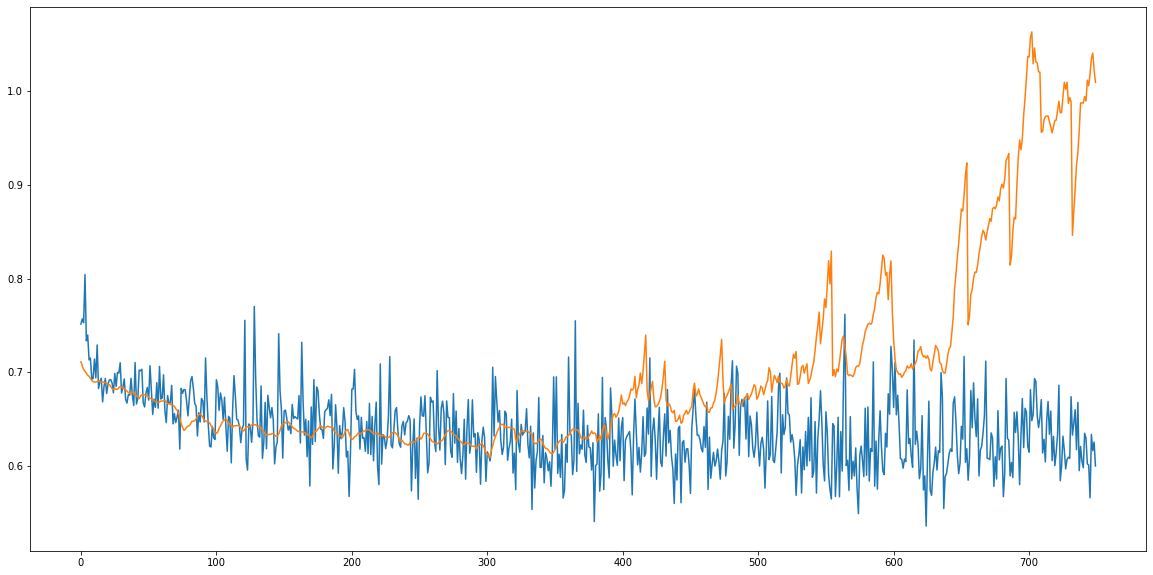

In [35]:
plt.figure(figsize=(20,10))

plt.plot(history[0][:750])
plt.plot(history[1][:750])

#### The training loss fluctuates since the loss is calculated after each batch, not at the end of each epoch.

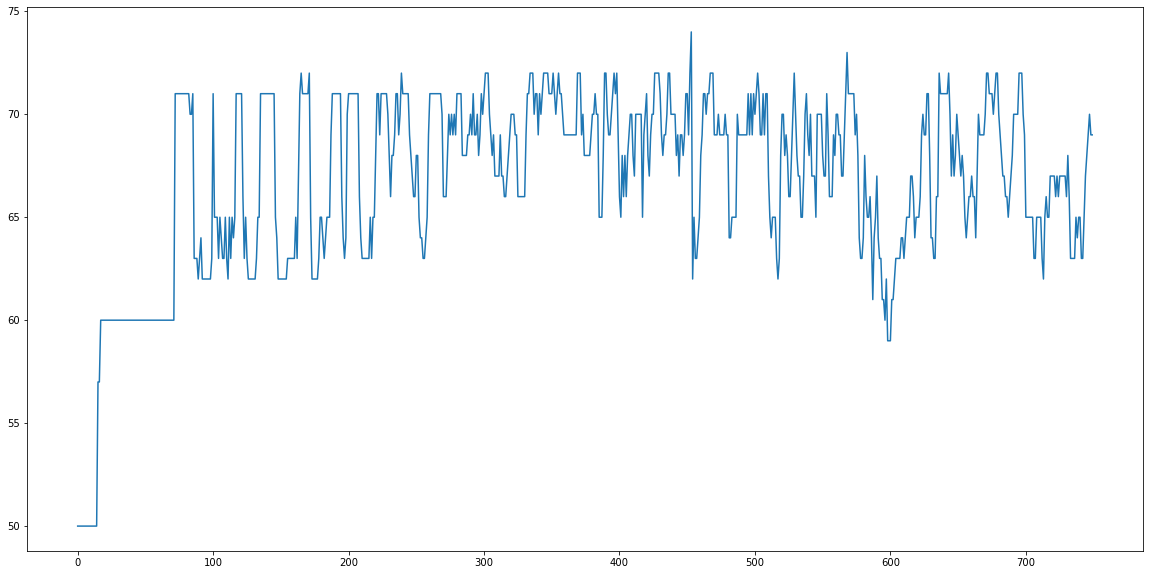

In [37]:
plt.figure(figsize=(20,10))
plt.plot(accuracy[:750])

#### Didn't show the outputs of the below two models since they are similar to the above one.

In [ ]:
model_B = Classifier(hidden_dim=32)
model_B, history_B, accuracy_B = train_model(model_B, "B")

In [ ]:
plt.plot(history_B[0][:500],label="Training Loss")
plt.plot(history_B[1][:500],label="Validation Loss")
plt.legend()

In [ ]:
model_C = Classifier(hidden_dim=16)
model_C, history_C, accuracy_C = train_model(model_C, "C")

In [ ]:
plt.plot(history_C[0],label="Training Loss")
plt.plot(history_C[1],label="Validation Loss")
plt.legend()

In [53]:
from sklearn import svm

train_x, train_y = zip(*input_data)

clf = svm.NuSVC()
clf.fit(train_x, train_y)

test_x = np.concatenate((test_data["0"],test_data["1"]),axis=0)
test_y = np.array([0]*50 + [1] * 50)

print(f"Accuracy from a simple SVM: {(100 - sum(abs(clf.predict(test_x) - test_y)))}% (For comparison purpose only)")

Accuracy from a simple SVM: 72% (For comparison purpose only)


In [38]:
#All three models achieved the highest accuracy of 77%, Selected the model with the lowest number of parameters
best_model = torch.load("model_C/77.0_accuracy.pt")
best_model

Classifier(
  (fc1): Linear(in_features=5, out_features=16, bias=True)
  (drop1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.625, inplace=False)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
  (drop3): Dropout(p=0.875, inplace=False)
  (fc4): Linear(in_features=4, out_features=2, bias=True)
)

### To increase the accuracy of the model, tried to create an ensemble network using the created 3 models

In [39]:
model_A = torch.load("model_A/77.0_accuracy.pt")   
model_B = torch.load("model_B/77.0_accuracy.pt")
model_C = torch.load("model_C/77.0_accuracy.pt")

models = [model_A, model_B, model_C]

In [40]:
total_predictions = []

for model in models:
    predictions = []
    model.eval()
    criterion = nn.NLLLoss()
    test_loss = 0
    accuracy = 0
    for inputs, labels in test_loader:
        logps = model.forward(inputs)
        ps = torch.exp(logps)
        batch_loss = criterion(logps, labels)
        test_loss += batch_loss.item()
        top_p, top_class = ps.topk(1, dim=1)
        predictions.append(top_class.numpy()[0])
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    total_predictions.append(np.array(predictions))

real_vals = []
for _, label in test_loader:
    real_vals.append(label.numpy())

total_predictions.append(np.array(real_vals))
total_predictions = np.array(total_predictions)

In [42]:
avg_pred = sum(total_predictions[:3,:,0])/3 > 0.5
print(f"Accuracy using the major vote of 3 models: {100 - sum(abs(avg_pred - test_y.numpy()))}%")

Accuracy using the major vote of 3 models: 77%


In [44]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB, modelC, hidden_dim=16):
        super(MyEnsemble, self).__init__()
        removed_A = list(model_A.children())[:-1]
        removed_B = list(model_B.children())[:-1]
        removed_C = list(model_C.children())[:-1]

        self.modelA = torch.nn.Sequential(*removed_A)
        self.modelB = torch.nn.Sequential(*removed_B)
        self.modelC = torch.nn.Sequential(*removed_C)
        
        self.fc1 = nn.Linear(removed_A[-2].out_features + removed_B[-2].out_features + removed_C[-2].out_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2)
        
    def forward(self, x):
        x1 = self.modelA(x.clone())  
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x.clone())
        x2 = x2.view(x2.size(0), -1)
        x3 = self.modelC(x.clone())
        x3 = x3.view(x3.size(0), -1)
        x = torch.cat((x1, x2, x3), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(F.leaky_relu(x), dim=1)
        return x

In [49]:
model_A = torch.load("model_A/77.0_accuracy.pt")   
model_B = torch.load("model_B/77.0_accuracy.pt")
model_C = torch.load("model_C/77.0_accuracy.pt")

for param in model_A.parameters():
    param.requires_grad_(False)

for param in model_B.parameters():
    param.requires_grad_(False)

for param in model_C.parameters():
    param.requires_grad_(False)


for dim in range(8,16):
    print("*"*20, f"Dim: {dim}", "*"*20)
    model = MyEnsemble(model_A, model_B, model_C, hidden_dim=dim)
    z = train_model(model, "Z")

******************** Dim: 8 ********************

Epoch no:  100
Training loss: 0.557 	 Testing loss: 0.656 	 Test accuracy: 0.630
Epoch no:  200
Training loss: 0.514 	 Testing loss: 0.659 	 Test accuracy: 0.650
Epoch no:  300
Training loss: 0.580 	 Testing loss: 0.657 	 Test accuracy: 0.660
Epoch no:  400
Training loss: 0.560 	 Testing loss: 0.657 	 Test accuracy: 0.670
Epoch no:  500
Training loss: 0.499 	 Testing loss: 0.666 	 Test accuracy: 0.650
Epoch no:  600
Training loss: 0.539 	 Testing loss: 0.666 	 Test accuracy: 0.680
Epoch no:  700
Training loss: 0.609 	 Testing loss: 0.659 	 Test accuracy: 0.660
Epoch no:  800
Training loss: 0.594 	 Testing loss: 0.670 	 Test accuracy: 0.680
Epoch no:  900
Training loss: 0.516 	 Testing loss: 0.679 	 Test accuracy: 0.640
Epoch no:  1000
Training loss: 0.581 	 Testing loss: 0.673 	 Test accuracy: 0.670
Best accuracy for lr=0.005: 70.0
******************** Dim: 9 ********************

Epoch no:  100
Training loss: 0.561 	 Testing loss: 0.66

In [50]:
model

MyEnsemble(
  (modelA): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=16, out_features=8, bias=True)
    (6): Dropout(p=0.7000000000000001, inplace=False)
  )
  (modelB): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=32, out_features=16, bias=True)
    (6): Dropout(p=0.7, inplace=False)
  )
  (modelC): Sequential(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): Dropout(p=0.25, inplace=False)
    (2): Linear(in_featur

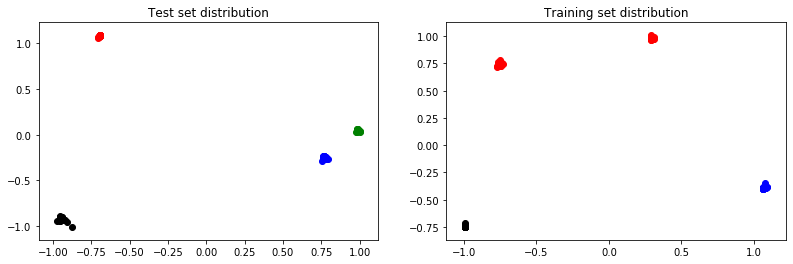

In [52]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm

kmeans = KMeans(n_clusters=4, random_state=0).fit(x1)

colors = ['b', 'r', 'k', 'g']
plt.figure(figsize=(28, 4))
plt.subplot(141)
plt.title("Test set distribution")
for y, c in zip(x1, kmeans.labels_):
    plt.scatter(y[0], y[1], color=colors[c])
    
clusters = kmeans.predict(x2)
# print(clusters)
plt.subplot(142)
plt.title("Training set distribution")
for y,z in zip(x2, clusters):
    plt.scatter(y[0], y[1], color=colors[z])

- Without blindly using an ensembled tried to see whether I could create clusters and train a model for each one of them to increase the accuracy. 
- The results from K-Means suggested that this approach might not work. 
- Therefore, **the best accuracy I achieved was 77.0%**
